### SAS Deep Learning Python (DLPy) Image Classification

## Outline

### 1. Business Problem

### 2. What is a Convolutional Neural Network?

### 3. Image Classification Model

### 4. Conclusion

## 1. Business Problem

Image classification or image recognition is the process of identifying people, places, objects, etc. from an image using machine learning, deep learning, and artificial intelligence.

Images are considered unstructured data because they come in various sizes and formats. Image classification techniques can allow us to add valuable information to this unstructured data. This practice is widely used in all industries. Examples include but are not limited to: defective product detection in production line, organizing and labeling user generated uploaded images (Social Media, Hotel / Vacation Rental, Restaurant Review), image search (search engines, product wall image search), medical imagery, and many more examples! For this example we'll be classifying product images to their appropriate product type.

## 2. What is a Convolutional Neural Network (CNN)? 

Before we build our deep learning model let's discuss what is a convolutional neural network (CNN). CNNs are a class of artificial neural networks. CNNs are widely used in image recognition and classification. Like regular neural networks, a CNN is composed of multiple layers and a number of neurons. CNNs are designed to take image data as input. This assumption allows CNNs to use structural information so that they are more computational efficient and use less memory. A typical CNN consists of four types of layers: input layer, convolution layer, pooling layer, and output layer. Each type of layer has its own specific properties and functionalities [1]. To learn more about CNNs you can visit [1. SAS CNN Overview](https://go.documentation.sas.com/?docsetId=casdlpg&docsetTarget=p0994iow7i7oqwn1vsk7xv2w4dz1.htm&docsetVersion=8.2&locale=en)

## 3. Image Classification Model

### Step 1 - Import Libraries and Connect to Server

In [1]:
import swat
import dlpy
from dlpy.splitting import two_way_split
from dlpy.applications import *
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Create CAS Connection
conn = swat.CAS(host, portnum, protocol='http')

### Step 2 - Load Data and View Summary Statistics

In [3]:
# Load the Retail Image Data
retail_training_images = dlpy.ImageTable.load_files(conn, path='/data/retail')

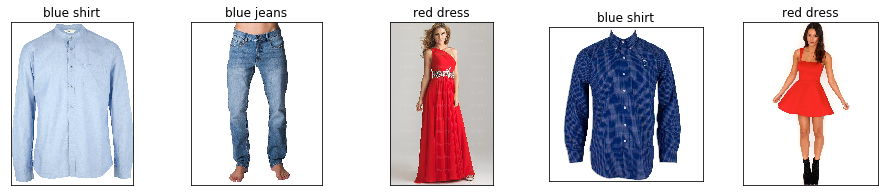

In [4]:
# Preview the Retail Images
retail_training_images.show(nimages=5, ncol=5, randomize=True)

In [6]:
# View the Retail Class Frequency
retail_training_images.label_freq

,Level,Frequency
black jeans,1,344
blue dress,2,386
blue jeans,3,356
blue shirt,4,369
red dress,5,380
red shirt,6,332


In [7]:
# View Image Summary
retail_training_images.image_summary

jpg                  2167
minWidth              313
maxWidth             5280
minHeight             277
maxHeight            7360
meanWidth         1075.22
meanHeight        1342.09
mean1stChannel    174.989
min1stChannel           0
max1stChannel         255
mean2ndChannel    166.346
min2ndChannel           0
max2ndChannel         255
mean3rdChannel    182.342
min3rdChannel           0
max3rdChannel         255
dtype: object

### Step 3 - Data Preparation

In [8]:
# Resize Images to 224x224
retail_training_images.resize(width=224, height=224, inplace=True)

In [9]:
# Shuffle Images
retail_training_images.shuffle(casout=dict(name='retail_training_images', replace=True));

In [10]:
# Split Data into Train / Test
train, test = two_way_split(retail_training_images, test_rate=20, seed=12345)

### Step 4 - Build Deep Learning Models

In [11]:
# Simple Convolutional Neural Network (CNN)
retail_simple_model = Sequential(conn, model_table='simple_cnn')

retail_simple_model.add(InputLayer(3,224,224, offsets=train.channel_means))

retail_simple_model.add(Conv2d(n_filters=8, width=7, height=7, stride=1, act='relu'))

retail_simple_model.add(Pooling(width=2, height=2, stride=2))

retail_simple_model.add(Conv2d(n_filters=8, width=7, height=7, stride=1, act='relu'))

retail_simple_model.add(Pooling(width=2, height=2))

retail_simple_model.add(Dense(n=16, act='relu'))

retail_simple_model.add(OutputLayer(act='softmax', n=6))

NOTE: Input layer added.
NOTE: Convolution layer added.
NOTE: Pooling layer added.
NOTE: Convolution layer added.
NOTE: Pooling layer added.
NOTE: Fully-connected layer added.
NOTE: Output layer added.
NOTE: Model compiled successfully.


In [14]:
# Preview Model Architecture
retail_simple_model.print_summary()

,Layer,Type,Kernel Size,Stride,Activation,Output Size,Number of Parameters
0,Input1,input,None,None,None,"(224, 224, 3)","(0, 0)"
1,Convo.1,convo,"(7, 7)",1,Relu,"(224, 224, 8)","(1176, 8)"
2,Pool1,pool,"(2, 2)",2,Max,"(112, 112, 8)","(0, 0)"
3,Convo.2,convo,"(7, 7)",1,Relu,"(112, 112, 8)","(3136, 8)"
4,Pool2,pool,"(2, 2)",2,Max,"(56, 56, 8)","(0, 0)"
5,F.C.1,fc,"(25088, 16)",None,Relu,16,"(401408, 0)"
6,Output1,output,"(16, 6)",None,Softmax,6,"(96, 6)"
7,,,,,,,405838


In [15]:
# Fit ResNet Deep Learning Model on GPU
retail_simple_model.fit(
                    data=train,
                    mini_batch_size=32,
                    max_epochs=10,
                    lr=0.001,
                    gpu=dict(devices=[1]),
                    n_threads=1,
                    log_level=2);

NOTE: Either dataspecs or inputs need to be non-None, therefore inputs=_image_ is used
NOTE: Training from scratch.
NOTE: dlgrd007.unx.sas.com: 1 out of 2 available GPU devices are used.
NOTE:  The Synchronous mode is enabled.
NOTE:  The total number of parameters is 405854.
NOTE:  The approximate memory cost is 128.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       1.07 (s).
NOTE:  The total number of threads on each worker is 1.
NOTE:  The total mini-batch size per thread on each worker is 32.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 32.
NOTE:  Target variable: _label_
NOTE:  Number of levels for the target variable:      6
NOTE:  Levels for the target variable:
NOTE:  Level      0: black jeans
NOTE:  Level      1: blue dress 
NOTE:  Level      2: blue jeans 
NOTE:  Level      3: blue shirt 
NOTE:  Level      4: red dress  
NOTE:  Level      5: red shirt  
NOTE:  Number of input variables:     1
NOTE: 

In [16]:
# View Training History
retail_simple_model.training_history

,Epoch,LearningRate,Loss,FitError
0,1,0.001,2.748795,0.847174
1,2,0.001,1.751595,0.827566
2,3,0.001,1.691285,0.743945
3,4,0.001,1.608594,0.683968
4,5,0.001,1.471297,0.600923
5,6,0.001,1.277224,0.509804
6,7,0.001,1.126780,0.431949
7,8,0.001,0.927969,0.350058
8,9,0.001,0.788654,0.286621
9,10,0.001,0.613715,0.235294


In [17]:
# Try Common Pre-Built ResNet 50 Model
retail_resnet_model = ResNet50_Caffe(
                        conn,
                        model_table='resnet50',
                        n_classes=6,
                        n_channels=3,
                        width=224,
                        height=224,
                        scale=1,
                        offsets=train.channel_means,
                        pre_trained_weights=True, 
                        pre_trained_weights_file='/data/retail/ResNet-50-model.caffemodel.h5',
                        include_top=False)

ERROR: Caffe model file not found.
ERROR: The action stopped due to errors.
NOTE: Model weights attached successfully!
ERROR: The file or path 'resnet50_weights' is not available in the file system.
ERROR: Table 'resnet50_weights' could not be loaded.
ERROR: Failure opening table 'resnet50_weights': A table could not be loaded.
ERROR: The action stopped due to errors.
NOTE: Model table is attached successfully!
NOTE: Model is named to "resnet50" according to the model name in the table.


In [18]:
# Fit ResNet Deep Learning Model on GPU
retail_resnet_model.fit(
                    data=train,
                    mini_batch_size=32,
                    max_epochs=10,
                    lr=0.001,
                    gpu=dict(devices=[1]),
                    n_threads=1,
                    log_level=2);

NOTE: Either dataspecs or inputs need to be non-None, therefore inputs=_image_ is used
NOTE: Training from scratch.
NOTE: dlgrd007.unx.sas.com: 1 out of 2 available GPU devices are used.
NOTE:  The Synchronous mode is enabled.
NOTE:  The total number of parameters is 23520390.
NOTE:  The approximate memory cost is 347.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       1.60 (s).
NOTE:  The total number of threads on each worker is 1.
NOTE:  The total mini-batch size per thread on each worker is 32.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 32.
NOTE:  Target variable: _label_
NOTE:  Number of levels for the target variable:      6
NOTE:  Levels for the target variable:
NOTE:  Level      0: black jeans
NOTE:  Level      1: blue dress 
NOTE:  Level      2: blue jeans 
NOTE:  Level      3: blue shirt 
NOTE:  Level      4: red dress  
NOTE:  Level      5: red shirt  
NOTE:  Number of input variables:     1
NOTE

In [19]:
# View Training History
retail_resnet_model.training_history

,Epoch,LearningRate,Loss,FitError
0,1,0.001,1.748013,0.749135
1,2,0.001,1.566901,0.648789
2,3,0.001,1.403108,0.548443
3,4,0.001,1.297980,0.493080
4,5,0.001,1.194440,0.441753
5,6,0.001,1.076019,0.382353
6,7,0.001,0.978792,0.332180
7,8,0.001,0.900859,0.303345
8,9,0.001,0.841132,0.279700
9,10,0.001,0.798212,0.275087


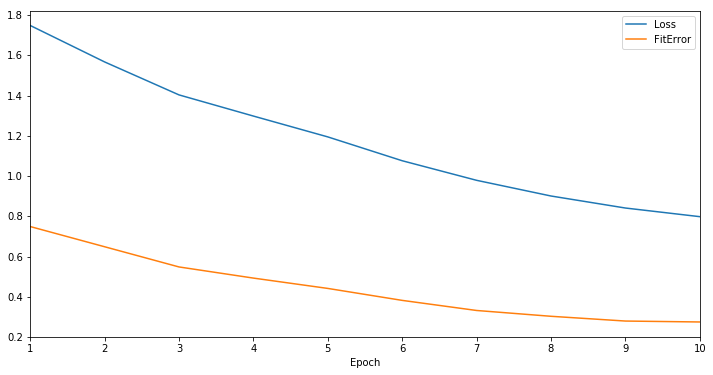

In [20]:
# Plot the Training and Validation Error
retail_resnet_model.plot_training_history(fig_size=(12,6), items=('Loss','FitError'))

### Step 5 - Test Error and View Predictions

In [21]:
# Score Test Data Using Simple Model
retail_simple_model.predict(test, gpu=dict(devices=[1]))

NOTE: Due to data distribution, miniBatchSize has been limited to 8.
NOTE: dlgrd007.unx.sas.com: 1 out of 2 available GPU devices are used.


[OutputCasTables]

             casLib              Name  Rows  Columns  \
 0  CASUSER(anviol)  Valid_Res_1fUHBc   433       13   
 
                                             casTable  
 0  CASTable('Valid_Res_1fUHBc', caslib='CASUSER(a...  

[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read           433
 1  Number of Observations Used           433
 2  Misclassification Error (%)      48.96074
 3                   Loss Error       1.76448

+ Elapsed: 2.02s, user: 1.52s, sys: 1.04s, mem: 1.8e+03mb

In [22]:
# Score Test Data Using Common Pre-built ResNet Model
retail_resnet_model.predict(test, gpu=dict(devices=[1]))

NOTE: Due to data distribution, miniBatchSize has been limited to 8.
NOTE: dlgrd007.unx.sas.com: 1 out of 2 available GPU devices are used.


[OutputCasTables]

             casLib              Name  Rows  Columns  \
 0  CASUSER(anviol)  Valid_Res_b7qlKC   433       13   
 
                                             casTable  
 0  CASTable('Valid_Res_b7qlKC', caslib='CASUSER(a...  

[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read           433
 1  Number of Observations Used           433
 2  Misclassification Error (%)      27.48268
 3                   Loss Error      0.761711

+ Elapsed: 3.65s, user: 3.18s, sys: 1.23s, mem: 774mb

NOTE: Cloud Analytic Services dropped table TEMP_PLOT from caslib CASUSER(anviol).


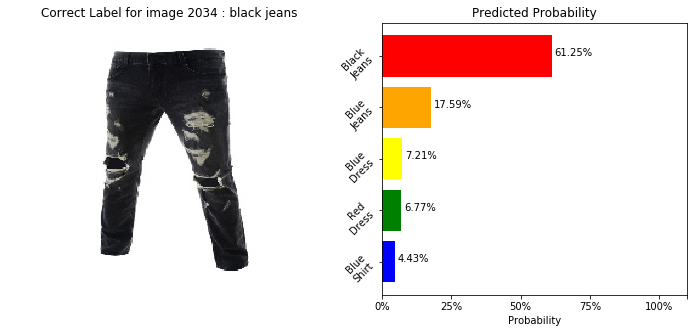

In [26]:
# Plot Predictions (Correct Classification)
retail_resnet_model.plot_evaluate_res(img_type='C', randomize=True, n_images=1)

NOTE: Cloud Analytic Services dropped table TEMP_PLOT from caslib CASUSER(anviol).


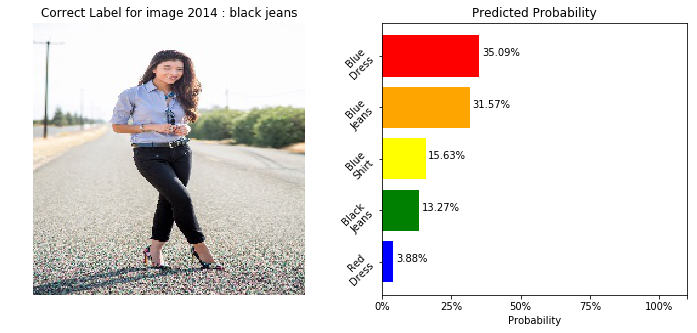

In [24]:
# Plot Predictions (Misclassification)
retail_resnet_model.plot_evaluate_res(img_type='M', randomize=True, n_images=1)

## 4. Conclusion

We've just completed building an image classification deep learning model on retail product images using the SAS high-level python API, DLPy. DLPy makes deep learning quick and easy with its user-friendly functionality. Hopefully you enjoyed this notebook and can use it on your next great image classification problem. Good luck!